# Objectives

In this notebook, I will analyze NYC MTA data for Calendar Year 2013. Specifically, I will answer the following data analysis and visualization questions: 

Data analysis:
- Which station has the most number of units?
- What is the total number of entries & exits across the subway system for February 1, 2013?
- Let’s define the busy-ness as sum of entry & exit count. What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
- What stations have seen the most usage growth/decline in 2013?
- What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely?
- Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

Visualization:
- Plot the daily row counts for data files in Q1 2013.
- Plot the daily total number of entries & exits across the system for Q1 2013.
- Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.
- Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt, matplotlib.patches as mpatches

In [2]:
def wide_to_long(long_df):
    """
    Converts MTA's "long" style dataframe to a standard style, moving each turnstile's audit from columns to rows    
    """
    cleaned_cols = ["C/A","UNIT","SCP","DATE","TIME","DESC","ENTRIES","EXITS"]
    df = pd.DataFrame(columns=cleaned_cols)
    for i in range(1,9):
        df = df.append(long_df.loc[:, long_df.columns.str.contains(f"C/A|UNIT|SCP|{i}")]\
                                    .rename(columns=lambda x: x[:-1] if x[:-1] in cleaned_cols else x), ignore_index=True)
    #Quality checks    
    null_check = sum(long_df.isna().sum()) == sum(df.isna().sum())
    entry_check = df.ENTRIES.sum() == sum([long_df[f"ENTRIES{i}"].sum() for i in range(1,9)])
    exit_check = df.EXITS.sum() == sum([long_df[f"EXITS{i}"].sum() for i in range(1,9)])
    assert null_check, "Null values not equal between initial load and transformed dataframe"
    assert entry_check, "Entry values not equal between initial load and trasformed dataframe"
    assert exit_check, "Exit values not equal between innitial load and transformed dataframe" 
    
    return df
    
def consolidate_timestamps(df):
    """
    Consolidates the DATE and TIME fields to a single datetime field called TIMESTAMP
    """
    df["DATETIME"] = pd.to_datetime(df["DATE"] + " " + df["TIME"], format="%m-%d-%y %H:%M:%S")
    return df.drop(columns=["DATE","TIME"])

def add_turnstile_id(df):
    """Create a unique ID based on combination of (C/A, UNIT, and SCP) and convert from string to unique int"""
    df["TURNSTILE"] = df["C/A"] + "_" + df["UNIT"] + "_" + df["SCP"]
    key_list = zip(df.TURNSTILE.unique(), range(0,len(df.TURNSTILE.unique())))
    key_hash = {turnstile: num for turnstile,num in key_list}
    df["TURNSTILE"] = df.TURNSTILE.map(key_hash)

In [3]:
field_list = "C/A,UNIT,SCP,DATE1,TIME1,DESC1,ENTRIES1,EXITS1,DATE2,TIME2,DESC2,ENTRIES2,EXITS2,DATE3,TIME3,DESC3,ENTRIES3,EXITS3,DATE4,TIME4,DESC4,ENTRIES4,EXITS4,DATE5,TIME5,DESC5,ENTRIES5,EXITS5,DATE6,TIME6,DESC6,ENTRIES6,EXITS6,DATE7,TIME7,DESC7,ENTRIES7,EXITS7,DATE8,TIME8,DESC8,ENTRIES8,EXITS8".split(",")
url = "http://web.mta.info/developers/turnstile.html"
#print(url)
page = requests.get(url)
page_soup = BeautifulSoup(page.content, 'html.parser')
load = pd.DataFrame()
for i in page_soup.body.find_all('a', href=True):
    if i.text.endswith("2013") or i.text == "Saturday, January 04, 2014" or i.text=="Saturday, December 29, 2012":
        print(f"{i.text} loading...")
        load = load.append(pd.read_csv("http://web.mta.info/developers/{}".format(i["href"]), header=None, names=field_list), ignore_index=True)
        print(f"{i.text} complete!")

#NOTE IF ERROR: ADDED IGNORE INDEX = TRUE

Saturday, January 04, 2014 loading...
Saturday, January 04, 2014 complete!
Saturday, December 28, 2013 loading...
Saturday, December 28, 2013 complete!
Saturday, December 21, 2013 loading...
Saturday, December 21, 2013 complete!
Saturday, December 14, 2013 loading...
Saturday, December 14, 2013 complete!
Saturday, December 07, 2013 loading...
Saturday, December 07, 2013 complete!
Saturday, November 30, 2013 loading...
Saturday, November 30, 2013 complete!
Saturday, November 23, 2013 loading...
Saturday, November 23, 2013 complete!
Saturday, November 16, 2013 loading...
Saturday, November 16, 2013 complete!
Saturday, November 09, 2013 loading...
Saturday, November 09, 2013 complete!
Saturday, November 02, 2013 loading...
Saturday, November 02, 2013 complete!
Saturday, October 26, 2013 loading...
Saturday, October 26, 2013 complete!
Saturday, October 19, 2013 loading...
Saturday, October 19, 2013 complete!
Saturday, October 12, 2013 loading...
Saturday, October 12, 2013 complete!
Saturda

In [4]:
load.to_pickle("2013_MTA.pkl")

In [5]:
load = pd.read_pickle("2013_MTA.pkl")

# Note: Before we begin...

You may wonder why I downloaded the last dataset of 2012 and the first dataset of 2014. 

2012 - In order to ensure that the <i> very first </i> entries of 2013 can be analyzed for growth, we need to know what the last entry value was in 2012 as a point of reference. Thus 2012 is needed to form the baseline, but will not be used for any of our 2013 analysis.

2013 - MTA reports data on a weekly basis, and the last datafile of 2013 was submitted on December 28th. That means that the remainder of that week's data (Dec 29, 30, and 31), will all be contained in the next dataset, which would be uploaded on January 4, 2013.

# Step 1: Cleaning
1. Transform data from wide-style format (e.g. columns represent more than one observation) into a long-style (with each row containing only one observation and multiple description fields)
2. Remove any discrepancies in the data (nulls entries, duplicate rows)
2. Ensure remaining data complies with MTA's intended format (e.g. only using entries with a "REGULAR" and "REGULAR AUD" DESC field


## Step 1.1 Wide to Long

Changing from wide to long style storage allows for more robust analysis to be conducted, and makes it easier to find data entries. This is also as good a time as any to optimize some of the field values for big-data analysis. Strings, for example, are notoriously slow to analyze, and can be converted to a "category" type data structure to save space and improve processing speed.

In [6]:
df = wide_to_long(load)
del(load)
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12833712 entries, 0 to 12833711
Data columns (total 8 columns):
C/A        12833712 non-null object
UNIT       12833712 non-null object
SCP        12833712 non-null object
DATE       11880690 non-null object
TIME       11880690 non-null object
DESC       11880690 non-null object
ENTRIES    11880690 non-null object
EXITS      11880690 non-null object
dtypes: object(8)
memory usage: 783.3+ MB


In [7]:
df = df.dropna()
add_turnstile_id(df)
df = consolidate_timestamps(df)
df["ENTRIES"] = df.ENTRIES.astype("int64")
df["EXITS"] = df.EXITS.astype("int64")
df[["C/A", "UNIT", "SCP", "DESC"]] = df[["C/A", "UNIT", "SCP", "DESC"]].astype("category")
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11880690 entries, 0 to 12833710
Data columns (total 8 columns):
C/A          11880690 non-null category
UNIT         11880690 non-null category
SCP          11880690 non-null category
DESC         11880690 non-null category
ENTRIES      11880690 non-null int64
EXITS        11880690 non-null int64
TURNSTILE    11880690 non-null int64
DATETIME     11880690 non-null datetime64[ns]
dtypes: category(4), datetime64[ns](1), int64(3)
memory usage: 532.6 MB


Would you look at that - by removing the nulls and optimizing the column datatypes, we cut the DataFrame's memory footprint by almost 33% (250 MB) despite adding a new turnstile identifier field! Since I'm on the road this week, this smaller size will be very hepful as I do the rest of my analysis on the laptop!

## Step 1.2: Remove offending data
Some of the older entries in the MTA dataset have a few problems. Null observations are inherent to the wide-style storage method, and some entries were duplicated. Let's fix that.

1st: As a part of the conversion, it looks like the Entries and Exit data was changed from int/float datatypes to object. Object data takes more storage space and is slower to calculate on; let's change that back. 

2nd: We can consolidate the "DATE" and "TIME" fields to a single unified "DATETIME" value. This saves space and also lets us utilize some of the powerful datetime features in Pandas.

### Duplicate Values
We'll handle duplicate data in the same way we handled null data - we'll drop it. By convention, dropping nulls in Python keeps the first instance of the data, so instead of double-or-triple counting a data point, we will only count it once - the proper way!

In [8]:
print(f"There are {sum(df.duplicated())} entries that have at least one duplicate row in the dataset. This represents {round(sum(df.duplicated())/len(df)*100, 5)}% of the data")
print("Deleting duplicates...")
df = df.drop_duplicates()
print(f"Deleted! There are {sum(df.duplicated())} entries that have at least one duplicate row in the dataset")

There are 11 entries that have at least one duplicate row in the dataset. This represents 9e-05% of the data
Deleting duplicates...
Deleted! There are 0 entries that have at least one duplicate row in the dataset


As we can see, all duplicate rows have now been removed

### Negative Turnstile values

In [9]:
print("Example of negative values:")
display(df[(df["ENTRIES"]<0) | (df["EXITS"]<0)].head())
print(f"There are {len(df[(df.ENTRIES < 0) | (df.EXITS < 0)])} total rows with negative data. This is {round(len(df[(df.ENTRIES<0)|(df.EXITS<0)])/len(df),5)}% of all rows")
print(f"There are {len(df[df.ENTRIES < 0])} total negative period entries. This is {round(len(df[df.ENTRIES < 0])/len(df),5)}% of all rows")
print(f"There are {len(df[df.EXITS < 0])} total negative period exits. This is {round(len(df[df.EXITS < 0])/len(df),5)}% of all rows")

Example of negative values:


,C/A,UNIT,SCP,DESC,ENTRIES,EXITS,TURNSTILE,DATETIME
1605,A069,R044,01-06-01,REGULAR,743485970,-807342891,257,2013-12-28 03:00:00
1606,A069,R044,01-06-01,REGULAR,743486127,-807338473,257,2013-12-29 11:00:00
1607,A069,R044,01-06-01,REGULAR,743486620,-807332628,257,2013-12-30 19:00:00
1608,A069,R044,01-06-01,REGULAR,743487039,-807328938,257,2013-12-31 19:00:00
1609,A069,R044,01-06-01,REGULAR,743487309,-807324535,257,2014-01-02 03:00:00


There are 15145 total rows with negative data. This is 0.00127% of all rows
There are 5606 total negative period entries. This is 0.00047% of all rows
There are 12678 total negative period exits. This is 0.00107% of all rows


As evidenced by the above, we have <i> almost 15,000 </i> rows with either negative entry or exit data. However, it's worth keeping in mind two key considerations:

1. Many of these rows with negative data appear to be consecutive, implying there's something wrong with the turnstile itself.
2. Based on the DATETIME field, the entry and exit data seems to be incrementing at a reasonable rate, despite the turnstile reading a negative. This means the turnstile is still counting positive passenger count within the period, as it should be. 

In this case, <b> I will not be removing negative values at this point based on turnstile count. </b> So long as the turnstile is counting properly, and I can calculate the cumulative passenger count as the year progresses, the absolute count itself is of little to no concern. Instead, I will wait until later in Step 2 of the analysis and handle <b> negative increments </b> instead. 

## Step 1.3: The Description Field
Per the field definitions provided by MTA, the machines' regularly transmitted data is contained within the "REGULAR" and "REGULAR AUD" entries. We will discard the other entries; additional research indicates the other entries referred to readings sent during maintenence.

Descn Possible Values (Events): (https://groups.google.com/g/mtadeveloperresources/c/yZmQnAt9W4M/m/LN5Q6EbsuSIJ) REGULAR - Regular scheduled audit event NO-VAL LGN - Not Valid logon LGF-MAN - Logoff Manual LGF-DR CLS - Logoff Door Closed LGF-SHUTDN - Logoff Shutdown TS BRD CHG - Turnstile Board Change TS VLT OPN - Turnstile Vault Open RECOVR AUD - Recovery audit - if REGULAR was not delivered due to communications problems

In [10]:
df.DESC.value_counts()

REGULAR       10322287
DOOR OPEN       532442
RECOVR AUD      459674
DOOR CLOSE      320803
LOGON           143573
LGF-MAN         101881
TS VLT OPN          15
TS BRD CHG           2
069                  1
064                  1
Name: DESC, dtype: int64

In [11]:
df = df.drop(index=df[~df["DESC"].str.contains("REGULAR|RECOVR AUD")].index)

In [12]:
df.DESC.value_counts()

REGULAR       10322287
RECOVR AUD      459674
TS VLT OPN           0
TS BRD CHG           0
LOGON                0
LGF-MAN              0
DOOR OPEN            0
DOOR CLOSE           0
069                  0
064                  0
Name: DESC, dtype: int64

# Step 2: Data Manipulation
1. Incremental Period Entry/Exits
    - Create the calculated field ((e.g. how many <i>more</i> people entered or exited within a specific interval)
        - This calculation requires values from late 2012 to determine the incremental count for the first entry of 2013. After this is calculated, we can remove all information outside of 2013.
    - Negative counts
    - High-value counts
2. Add additional calculated fields if necessary

In [13]:
#Sort Dataframes by unique identifier (CA,UNIT,SCP) and sort by datetime
df = df.sort_values(by=["TURNSTILE", "DATETIME"])
df["PERIOD ENTRIES"] = df["ENTRIES"] - df.groupby(["TURNSTILE"]).shift(1)["ENTRIES"]
df["PERIOD EXITS"] = df["EXITS"] - df.groupby(["TURNSTILE"]).shift(1)["EXITS"]
df.describe()

,ENTRIES,EXITS,TURNSTILE,PERIOD ENTRIES,PERIOD EXITS
count,1.078196e+07,1.078196e+07,1.078196e+07,1.077737e+07,1.077737e+07
mean,4.976213e+06,2.901892e+06,2.280096e+03,9.466632e+02,7.406240e+02
std,3.278294e+07,3.241775e+07,1.307716e+03,9.426708e+05,9.348571e+05
min,-9.314769e+08,-8.789758e+08,0.000000e+00,-9.314769e+08,-9.797130e+08
25%,3.311260e+05,1.919650e+05,1.139000e+03,8.000000e+00,6.000000e+00
50%,1.958152e+06,1.217307e+06,2.291000e+03,6.900000e+01,4.800000e+01
75%,5.038735e+06,3.626571e+06,3.388000e+03,2.320000e+02,1.620000e+02
max,9.168487e+08,9.797130e+08,4.630000e+03,9.168486e+08,9.719247e+08


In [14]:
print(f"Deleting {len(df[df.DATETIME.dt.year!=2013])} rows of non-2013 data.")
df = df.drop(index = df[df.DATETIME.dt.year!=2013].index)      
print(f"Deleted! {len(df)} rows remain, representing {len(df[df.DATETIME.dt.year!=2013])} rows of 2013 data")

Deleting 365799 rows of non-2013 data.
Deleted! 10416162 rows remain, representing 0 rows of 2013 data


## Step 2.2: Incremental passenger counts


Looking at how the period Entries/Exits values are distributed, it is clear that we have some rotten entries - both too high and too low. Both entries and exits have a mean value in the high hundreds, but <i> both </i> of the the incremental fields' have min and max values in the <b>BILLIONS</b>. Of course, we can also look at this graphically, but regardless of how we look at it, we need to clean up the magnitutde problem.

Which of course, brings us back to our earlier problem: <b> negative values </b>. The turnstile functions like an odometer; it should never count down, unless a turnstile rolling over from it's maximum and starting over again. Since the raw entry and exit counts suggest that the turnstiles can easily count over <b> 9 billion users </b> before recounting, we would expect roll-over values to be in the order of negative 9 billion. As it stands, the negative values have a mean of around <b> 1 million </b> - suggesting there's some other culprit behind these negative values behind a simple maxing out of the turnstile counter. 

There are a few options to handle these negative numbers: we could remove the rows from the dataset entirely, we could impute the value based on other features (e.g. the turnstile's mean), or we could go even further into the weeds of imputing and come up with a mean value for each turnstile at a certain time of day. 

Before we decide how to handle the negative data, let's see 
1. Whether the data represents a significant portion of the dataset
2. Whether the data will significantly impact our analysis (most questions revolve around February 1st) 

In [15]:
print("Mean of columns:")
print(df[(df["PERIOD ENTRIES"]<0) | (df["PERIOD EXITS"]<0)][["PERIOD ENTRIES", "PERIOD EXITS"]].mean())
print(f"There are {len(df[(df['PERIOD ENTRIES']<0) | (df['PERIOD EXITS']<0)])} total rows with negative data. This is {round(len(df[(df['PERIOD ENTRIES']<0)|(df['PERIOD EXITS']<0)])/len(df)*100,5)}% of all rows")
print(f"There are {len(df[df['PERIOD ENTRIES'] < 0])} total negative period entries. This is {round(len(df[df['PERIOD ENTRIES'] < 0])/len(df)*100,5)}% of all rows")
print(f"There are {len(df[df['PERIOD EXITS'] < 0])} total negative period exits. This is {round(len(df[df['PERIOD EXITS'] < 0])/len(df)*100,5)}% of all rows")

Mean of columns:
PERIOD ENTRIES   -8.921038e+05
PERIOD EXITS     -1.063659e+06
dtype: float64
There are 1879 total rows with negative data. This is 0.01804% of all rows
There are 1630 total negative period entries. This is 0.01565% of all rows
There are 1496 total negative period exits. This is 0.01436% of all rows


Unfortunately my laptop keeps running into a memory error if I try to run multiple filters on the whole the whole dataset, so let's cut it down to just the Feb 1 data. It is important to consider that rides from February 1 could also be included in the <b> RECOVERED AUDITS </b> opened on February 2nd. 

In [16]:
feb_1 = df[df.DATETIME=="2013-02-01"]
feb_1.append(df[(df.DESC == "RECOVR AUD") & (df.DATETIME=="2013-02-02")]);

In [17]:
feb_1[(feb_1["PERIOD ENTRIES"]<0) | (feb_1["PERIOD EXITS"]<0)]

,C/A,UNIT,SCP,DESC,ENTRIES,EXITS,TURNSTILE,DATETIME,PERIOD ENTRIES,PERIOD EXITS
11061795,JFK01,R535,00-00-03,REGULAR,11,13,809,2013-02-01,-8641.0,-50146.0


In [18]:
df.groupby("TURNSTILE").mean().loc[809, ["PERIOD ENTRIES", "PERIOD EXITS"]]

PERIOD ENTRIES    11.273554
PERIOD EXITS      69.761983
Name: 809, dtype: float64

There's only one datapoint across all of the February 1 data that has negative entries or exits, and while period values look relatively large (<-8000 entries, <-50k exits), the baseline Entry/Exit field looks to be reasonably in line with the turnstile's annual average (11:11 entries, 13:70 exits). We could either assume that the turnstile was arbitrarily reset and include the data by replacing the current period values with the base entries/exits, or remove the row entirely. Given the lack of data coupled with the lack of available context, I have decided to remove the row entirely. 

I will extend this approach out to the other rows with negative data as well, to be consistent. 

Note: This is only a viable solution because the negative data represents an immaterial portion of our dataset; only ~0.01% of all rows contain a negative period entry or exit value.

In [19]:
df = df.drop(df[(df["PERIOD ENTRIES"]<0) | (df["PERIOD EXITS"]<0)].index)
feb_1 = df[df.DATETIME=="2013-02-01"]
feb_1.append(df[(df.DESC == "RECOVR AUD") & (df.DATETIME=="2013-02-02")]);

In [20]:
feb_1[(feb_1["PERIOD ENTRIES"]<0) | (feb_1["PERIOD EXITS"]<0)]

,C/A,UNIT,SCP,DESC,ENTRIES,EXITS,TURNSTILE,DATETIME,PERIOD ENTRIES,PERIOD EXITS


In [21]:
print("Master Dataframe rows with negative period entry/exits: ")
display(df[(df["PERIOD ENTRIES"] < 0) | (df["PERIOD EXITS"] < 0)])

Master Dataframe rows with negative period entry/exits: 


,C/A,UNIT,SCP,DESC,ENTRIES,EXITS,TURNSTILE,DATETIME,PERIOD ENTRIES,PERIOD EXITS


Perfect, no more negatives. Now we arrive at our second problem: the stupidly big passenger counts. 

In [22]:
del(feb_1)

In [23]:
df.describe()

,ENTRIES,EXITS,TURNSTILE,PERIOD ENTRIES,PERIOD EXITS
count,1.041428e+07,1.041428e+07,1.041428e+07,1.041409e+07,1.041409e+07
mean,4.997245e+06,2.908371e+06,2.279696e+03,1.047994e+03,8.980759e+02
std,3.298211e+07,3.260830e+07,1.307465e+03,5.816020e+05,6.475368e+05
min,-9.314769e+08,-8.789650e+08,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.313800e+05,1.919095e+05,1.139000e+03,8.000000e+00,6.000000e+00
50%,1.959986e+06,1.217699e+06,2.291000e+03,7.000000e+01,4.900000e+01
75%,5.044857e+06,3.628585e+06,3.387000e+03,2.350000e+02,1.640000e+02
max,9.168487e+08,9.797130e+08,4.617000e+03,7.714383e+08,9.719247e+08


As we can see (again) above, Period Entries and Period Exits have maximum values that are <i> orders of magnitude </i> larger than both the mean and the 50%ile. To reiterate how large this difference is, seeing a value ending in e2, like the mean, indicates a value in the 100s. A value ending in e8 ends in the <b>BILLIONS</b>, which is absolutely impossible for a single subway stop in NYC to accomplish within the standard 4 hour turnstile window.

But what is the proper cutoff for something like this? 

Well, the first thing I would want to do is look at the distribution graphically, but unfortunately I'm not sure my computer can plot that out in any reasonable amount of time. 

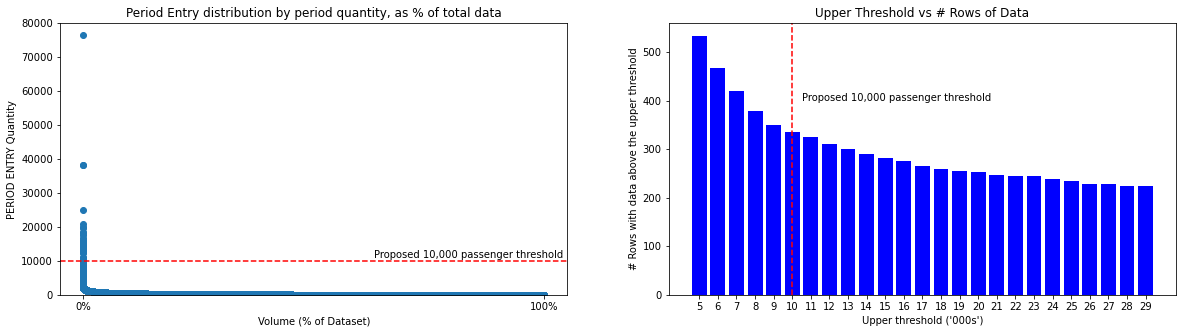

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5));

temp = df.drop(columns=["C/A","UNIT","SCP","DESC","TURNSTILE","ENTRIES", "EXITS"])[df.DATETIME < "2013-04-01"].sort_values(by="PERIOD ENTRIES",ascending=False)
ax1.scatter(x=temp.reset_index().index, y=temp["PERIOD ENTRIES"])
#Set y_scale to log to show all outliers. Alternatively, set y_lim to 80000 to show most outliers, but miss the most egregious
ax1.set_yscale('symlog')
#ax1.set_ylim([0, 80000]);
ax1.axhline(y=10000, color='r', linestyle='--');
ax1.set_title("Period Entry distribution by period quantity, as % of total data")
ax1.set_xticks([0, max(temp.reset_index().index)])
ax1.set_xticklabels(["0%", "100%"])
ax1.set_ylabel("PERIOD ENTRY Quantity");
ax1.set_xlabel("Volume (% of Dataset)");
ax1.annotate("Proposed 10,000 passenger threshold", (1600000,11000))
del(temp)

for x, lim in enumerate(range(5000, 30000, 1000)):
    ax2.bar(x, len(df[((df["PERIOD ENTRIES"]>lim) | (df["PERIOD EXITS"]>lim))]), color="blue")
ax2.set_xticks([x for x, lim in enumerate(range(5000, 30000, 1000))])
ax2.set_xticklabels([int(x/1000) for x in range(5000, 30000, 1000)])
ax2.set_title("# Rows of Data Containing Values > Upper Threshold")
ax2.set_title("Upper Threshold vs # Rows of Data")
ax2.set_ylabel("# Rows with data above the upper threshold");
ax2.set_xlabel("Upper threshold ('000s')");
ax2.axvline(x=5, color='r', linestyle='--');
ax2.annotate("Proposed 10,000 passenger threshold", (5.5,400));

Based on this distribution, it looks like most of the passenger data falls below 10,000 entries within the 4-hour reporting window. Let's give 10,000 a sanity check as an upper bound:

Assumptions: 
- 1 turnstile can only be used by 1 person at a time       
- 1 passenger can pass through the turntstile every 1 second

With these assumptions, knowing that there are 3600 secoonds in an hour and 4 hours in each reporting period, a turnstile can acommodate up to 14,400 passengers in a period if people flow through with no breaks. Is it reasonable to assume that people will continuously flow through a turnstile with no breaks, even in a crowded metropolois like NYC? My time living in Hong Kong has taught me that no, even during rush hour there will be breaks. As such, we'll decrease this 14,400 figure down the the 10,000 we found looking at the data graphically, and use the 10k as our upper bound.  

Let's take a quick look if any of these entries will impact our February 1st analysis to acknowledge any potential monkey wrenches, and then drop the data.

In [25]:
df[((df["PERIOD ENTRIES"]>10000) | (df["PERIOD EXITS"]>10000)) & (df["DATETIME"]=="2013-02-01")]

,C/A,UNIT,SCP,DESC,ENTRIES,EXITS,TURNSTILE,DATETIME,PERIOD ENTRIES,PERIOD EXITS


In [26]:
print(f'Rows with values exceending 10000 period entries or exits account for {round(len(df[((df["PERIOD ENTRIES"]>10000) | (df["PERIOD EXITS"]>10000))])/len(df)*100,5)}% of the dataset')

Rows with values exceending 10000 period entries or exits account for 0.00323% of the dataset


Excellent, nothing there. Let's drop the offending data. Also, now that we've finished cleaning our period entry/exit and all our analysis will be based on those moving forward, we can go ahead and drop the original cumulative entries/exits fields.

In [27]:
print(f'Dropping {len(df[(df["PERIOD ENTRIES"]>10000) | (df["PERIOD EXITS"]>10000)])} rows with entry or exit values over 10,000...')
df = df.drop(index=df[(df["PERIOD ENTRIES"]>10000) | (df["PERIOD EXITS"]>10000)].index)
print("Drop complete.")
      
print(f'Dropping original entry and exit columns')
df = df.drop(columns=["ENTRIES", "EXITS"])
print("Drop complete.")
      

Dropping 336 rows with entry or exit values over 10,000...
Drop complete.
Dropping original entry and exit columns
Drop complete.


In [28]:
df.describe()

,TURNSTILE,PERIOD ENTRIES,PERIOD EXITS
count,1.041395e+07,1.041376e+07,1.041376e+07
mean,2.279688e+03,1.733291e+02,1.360616e+02
std,1.307465e+03,2.599782e+02,2.354630e+02
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.139000e+03,8.000000e+00,6.000000e+00
50%,2.291000e+03,7.000000e+01,4.900000e+01
75%,3.387000e+03,2.350000e+02,1.640000e+02
max,4.617000e+03,9.890000e+03,9.571000e+03


# Step 3: Join the Station List

Whoooo boy, that was fun. Now let's go ahead and match each turnstile to its corresponding MTA station. The MTA has kindly provided a mapping - let's take a look.

In [29]:
station_list = pd.read_excel("http://web.mta.info/developers/resources/nyct/turnstile/Remote-Booth-Station.xls")

First step is just to ensure the data is cleaned, i.e. all the Remote-booth pairs are unique. If there <i> are </i> duplicates, we're going to have a big problem...

In [30]:
sum(station_list.duplicated(subset=(["Remote", "Booth"])))

0

Thank goodness, the pairs are unique. Crisis averted before it began. Now we can go ahead and join the station name to the original dataset based on the unique Remote + Booth combination.

The station list the MTA provided has Station, Line Name, and Division information, but for the sake of this analysis, we only require the Station information.

In [31]:
station_list.head(2)

,Remote,Booth,Station,Line Name,Division
0,R001,A060,WHITEHALL ST,R1,BMT
1,R001,A058,WHITEHALL ST,R1,BMT


In [32]:
master = pd.merge(df, station_list[["Remote", "Booth", "Station"]], left_on=["UNIT", "C/A"], right_on=["Remote","Booth"], how="left")
master = master.drop(columns=["Remote", "Booth"])
assert master['Station'].isna().sum() == 0, f"There are {master['Station'].isna().sum()} null station values in the combined dataframe. This represents {len({master['Station'].isna().sum()/len(master)*100})}% of the dataframe"

AssertionError: There are 190156 null station values in the combined dataframe. This represents 1% of the dataframe

It looks like there are some entries where the combination of Remote and Booth do not exist in the station list. Let's work from the bottom-up and start with the remote value first.

First thing to do is confirm that whether the Remote value has a 1:1 relationship with each station. If so, we can remap the null values according to the remote. If the relationship is 1:many, we'll need to take a different approach.

In [33]:
master[master['Station'].isna()][["UNIT","C/A"]].drop_duplicates().sort_values(by="UNIT")

,UNIT,C/A
6247336,R001,R101
601029,R028,A077
610129,R028,A081
626013,R028,A082
3072440,R028,N098
9883324,R057,R612
10407710,R088,A049
7020575,R168,R169
4272982,R202,N330
10353485,R538,LGA02


In [34]:
display(station_list[station_list["Remote"].isin(master[master['Station'].isna()]["UNIT"])].
        groupby("Remote").nunique()["Station"])

Remote
R001    2
R028    1
R057    2
R088    1
R168    1
R202    1
R538    1
Name: Station, dtype: int64

In [35]:
station_list[station_list["Remote"].isin(["R057", "R001"])][["Remote", "Booth","Station"]]

,Remote,Booth,Station
0,R001,A060,WHITEHALL ST
1,R001,A058,WHITEHALL ST
2,R001,R101S,SOUTH FERRY
127,R057,R610,ATLANTIC AVE
128,R057,B001,ATLANTIC AVE
129,R057,B002,ATLANTIC AVE
130,R057,C009,PACIFIC ST


Of the 5 remotes that don't have a 1:1 relationship, R001 C/A R101 looks to obviously correspond to R001 booth R101<b>S</b>, so we can go ahead and consider those entries to belong to South Ferry.

R057 C/A 612 most closely follows the naming convention of R057 Booth 610, and based on 75% of the Remote's booth's sharing the same Atlantic Ave station, I am comfortable to assign that this entry to Atlantic Ave as well. 

In [36]:
for unit in master[master['Station'].isna()]["UNIT"].unique():
    if unit is "R057":
        master.loc[(master['Station'].isna()) & (master["UNIT"] == unit), ["Station"]] = "ATLANTIC AVE"
    elif unit is "R001":
        master.loc[(master['Station'].isna()) & (master["UNIT"] == unit), ["Station"]] = "SOUTH FERRY"
    else:
        master.loc[(master['Station'].isna()) & (master["UNIT"] == unit),["Station"]] = station_list[station_list["Remote"]==unit]["Station"].iloc[0]
        
assert master['Station'].isna().sum() == 0, f"There are {master['Station'].isna().sum()} null station values in the combined dataframe."

In [37]:
master.to_pickle("MTA_Master.pkl")

# DATA ANALYSIS

### 1: Which station has the most number of units?

Philisophically speaking, what really <i> is </i> a unit anyway? A remote unit, or a turnstile?

This question specifically asks about units, which is of course the name of a field in the provided data table that corresponds to a remote unit (which can have multiple turnstiles, denoted by the SCP). However, in the context of this analysis, this question makes more sense if it is asking about units as a measure of total number of turnstiles.

I will first answer which station has the greatest number of remote units, and then which has the most individual turnstiles

### UNITS, AS DEFINED BY THE DATA FIELD

In [38]:
display(master.groupby("Station")["UNIT"].nunique().sort_values(ascending=False).head(5))
temp = master.groupby("Station")["UNIT"].nunique().sort_values(ascending=False)
print(f"The station with the most remote units is: {temp.index[0]} with {temp.iloc[0]} units")
del(temp)

Station
CANAL ST           5
86 ST              5
42 ST-GRD CNTRL    4
34 ST-PENN STA     4
125 ST             4
Name: UNIT, dtype: int64

The station with the most remote units is: CANAL ST with 5 units


### UNITS, AS DEFINED AS NUMBER OF INDIVIDUAL TURNSTILES

To answer the turnstile question, we need more than just the Remote and Booth information we used to join the stations - we also need the SCP. The SCP represents a specific address for a device, indicating a unique turnstile. Luckily, we already created the TURNSTILE field earlier, which is a combination of C/A (Booth), UNIT (Remote), and SCP. We'll use that field for this analysis.

In [39]:
master.groupby("Station")["TURNSTILE"].nunique().sort_values(ascending=False).head(5)

Station
34 ST-PENN STA     100
FULTON ST           81
42 ST-GRD CNTRL     62
42 ST-TIMES SQ      60
CANAL ST            56
Name: TURNSTILE, dtype: int64

In [40]:
temp = master.groupby("Station")["TURNSTILE"].nunique().sort_values(ascending=False)
print(f"The station with the most turnstiles is: {temp.index[0]} with {temp.iloc[0]} turnstiles")
del(temp)

The station with the most turnstiles is: 34 ST-PENN STA with 100 turnstiles


This list seems in line with the [MTA's self-published list of station traffic](http://web.mta.info/nyct/facts/ffsubway.htm), which in encouraging.

### 2. What is the total number of entries & exits across the subway system for February 1, 2013?

This sounds like a straightforward question - just filter for rows with a DATETIME of February 1, 2013, right? Normally that would be right, but the MTA also publishes recovery audit data, which could hold ridership data from the day before (or even previous days). Let's take a look at that first. 

In [41]:
for i in range(1,6):
    print(f'Audit reports received on 2013-02-0{i}: {len(master[(master.DESC == "RECOVR AUD") & (master.DATETIME ==f"2013-02-0{i}")])}')

Audit reports received on 2013-02-01: 6
Audit reports received on 2013-02-02: 25
Audit reports received on 2013-02-03: 5
Audit reports received on 2013-02-04: 9
Audit reports received on 2013-02-05: 11


Hm... so the RECOVR AUDs aren't sent on a regular basis. Fair enough - if they they were, they'd probably be considered "REGULAR." But is there any way to asses how many days an audit's data is held for before it was submitted? Let's go ahead and take a look at the aduits that were submitted on Feb 2nd.

In [42]:
temp = master[(master.DESC == "RECOVR AUD") & (master.DATETIME ==f"2013-02-02")]
temp.describe()

,TURNSTILE,PERIOD ENTRIES,PERIOD EXITS
count,25.000000,25.00000,25.000000
mean,3336.280000,359.84000,153.000000
std,1209.881038,459.26578,201.074406
min,1489.000000,0.00000,0.000000
25%,1495.000000,27.00000,19.000000
50%,3716.000000,107.00000,82.000000
75%,4390.000000,705.00000,179.000000
max,4396.000000,1557.00000,818.000000


We can easily calculate the difference between the audit value and the standard 4-hour interval value. By reporting the audit value as a % of the standard entry, we can get an estimate as to how long the audit report has been sitting in the machine; a value of 100% would imply that the audit has been sitting for approximately 4 hours, as it would lines up with the average 4-hour entry across the year. 

In the same way, a value of 200% would imply the data was sitting in the queue for 8 hours, so on and so forth until we pass the 24 hour threshold entirely at 600% (6 * 4 = 24). 

As the audit reports are logged at midnight, and NYC Subway runs 24/7 in non-covid conditions such as those in 2013, rows where both entries and exits are within 600% are vaiable candidates to be considered within the scope of the previous day. 

In [43]:
(temp.groupby("TURNSTILE").mean()/master[master.TURNSTILE.isin(temp.TURNSTILE)].groupby("TURNSTILE").mean()*100).sort_values(by="PERIOD ENTRIES", ascending=False).fillna(0)

,PERIOD ENTRIES,PERIOD EXITS
TURNSTILE,,
4392,1105.314010,0.000000
3711,692.107275,548.861315
3718,657.937065,1279.302587
3713,649.924503,604.990142
3715,622.478008,603.016159
3717,619.322431,1090.771140
3714,617.475484,715.773800
3716,607.988263,552.917638
3719,577.805270,984.877809


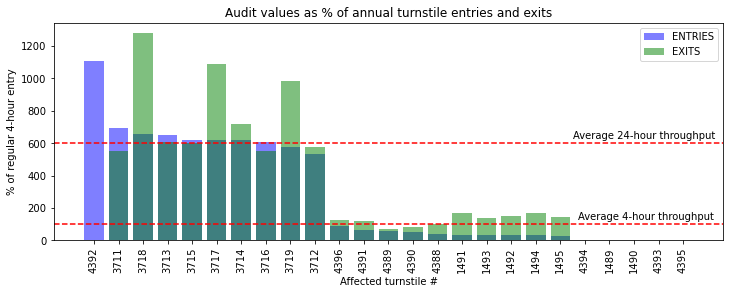

In [44]:
fig, ax = plt.subplots(figsize=(12, 4))
audit2 = (temp.groupby("TURNSTILE").mean()/master[master.TURNSTILE.isin(temp.TURNSTILE)].groupby("TURNSTILE").mean()*100).sort_values(by="PERIOD ENTRIES", ascending=False).fillna(0)
plt.figsize = (60,10)
plt.bar(audit2.reset_index().index, audit2["PERIOD ENTRIES"], color="blue", alpha=.5)
plt.bar(audit2.reset_index().index, audit2["PERIOD EXITS"], color="green", alpha=.5)
plt.legend(["ENTRIES", "EXITS"], loc="upper right")
plt.axhline(y=100, color='r', linestyle='--');
plt.annotate("Average 4-hour throughput", (19.7,130))
plt.axhline(y=600, color='r', linestyle='--');
plt.annotate("Average 24-hour throughput", (19.5,630))
plt.ylabel("% of regular 4-hour entry")
plt.xticks(np.linspace(0,len(audit2)-1,(len(audit2))), audit2.index, rotation=90)
plt.xlabel("Affected turnstile #")
plt.title("Audit values as % of annual turnstile entries and exits");

Looks like one turnstile has a total of zero entries and ~1100 exits in this audit. Weird. Maybe it's a one way turnstile, but if I were the MTA I'd want to check that datapoint out.

In [45]:
temp = temp[temp.TURNSTILE.isin(audit2[(audit2["PERIOD ENTRIES"] <= 600) & (audit2["PERIOD EXITS"] <= 600)].index)]
del(audit2)

In [46]:
feb1 = master[master.DATETIME=="2013-02-1"].append(temp)

### ANSWER

In [47]:
print(f'Total entries on February 1 2013: {feb1["PERIOD ENTRIES"].sum()}')
print(f'Total exits on February 1 2013: {feb1["PERIOD EXITS"].sum()}')

Total entries on February 1 2013: 211626.0
Total exits on February 1 2013: 190797.0


The entry and exits numbers are relatively close, but have a discrepancy of over 10%. Some of this discrepancy can almost certainly be attributed to entries trapped in audit reports, and some of this may be due to evening passengers not exiting until later the next day, but all of it?  

Let's take a look at how the data stacks up as a whole

In [48]:
print(f"The total discrepancy of entries to exits in the dataset is {master['PERIOD ENTRIES'].sum() - master['PERIOD EXITS'].sum()} more entries than exits")

The total discrepancy of entries to exits in the dataset is 388094621.0 more entries than exits


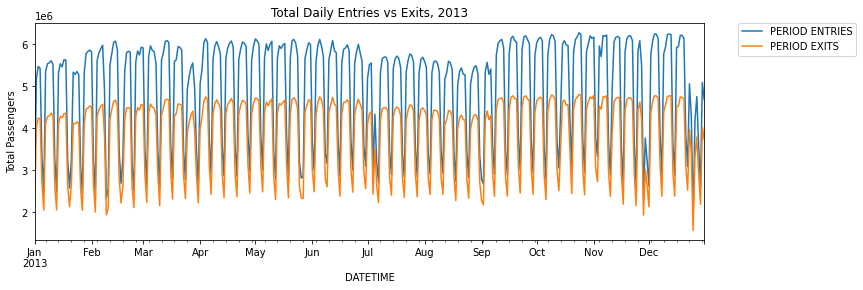

In [49]:
ax = master.set_index("DATETIME").resample("D").sum()[["PERIOD ENTRIES", "PERIOD EXITS"]].plot(figsize=(12,4));
plt.title("Total Daily Entries vs Exits, 2013")
plt.ylabel("Total Passengers")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

However, this discrepancy is certainly an area for the MTA to look into.
- If this discrepancy is accounted for by the audit reports opened at later dates, can the MTA schedule a more regular auditing process, or find a way to add time-stamps to visitors and save them in the audits? 
- The MTA should review its data collection policies and turnstile reset timing to make sure data is not getting swallowed by the system; the master data table has a significant discrepancy of entries to exits (see below). Based on the data collection rates for exits, exit data is either being transmitted by a non-standard DESC code, or perhaps stations to not mandate passengers scan their ticket when leaving stations.
- Alternative interpretation: is the MTA mislabeling exit data as entry data?


In [50]:
del (ax,ax1,ax2,fig,temp,x,i,field_list,page,page_soup)

### 3: What station was the busiest on February 1, 2013? What turnstile was the busiest on that date?
Let’s define the busy-ness as sum of entry & exit count, and rename "busyness" to "throughput."

In [51]:
feb1["THROUGHPUT"] = feb1["PERIOD ENTRIES"] + feb1["PERIOD EXITS"]

### ANSWER

In [52]:
display(feb1.groupby("Station")["THROUGHPUT"].sum().sort_values(ascending=False).head(5))
temp = feb1.groupby("Station")["THROUGHPUT"].sum().sort_values(ascending=False)
print(f"The busiest station on February 1 2013 was: {temp.index[0]} with {temp.iloc[0]} total passengers entering and/or exiting")
del(temp)

Station
14 ST-UNION SQ     28450.0
W 4 ST-WASH SQ     14839.0
96 ST              13244.0
42 ST-GRD CNTRL    12728.0
23 ST              12491.0
Name: THROUGHPUT, dtype: float64

The busiest station on February 1 2013 was: 14 ST-UNION SQ with 28450.0 total passengers entering and/or exiting


In [53]:
display(feb1.groupby(["Station", "TURNSTILE"])["THROUGHPUT"].sum().sort_values(ascending=False).head(5))
temp = feb1.groupby(["Station", "TURNSTILE"])["THROUGHPUT"].sum().sort_values(ascending=False)
print(f"The busiest turnstile on February 1 2013 was: Turnstile {temp.index[0][1]} at {temp.index[0][0]} with {temp.iloc[0]} total passengers entering and/or exiting")
del(temp)

Station         TURNSTILE
W 4 ST-WASH SQ  1274         1802.0
14 ST-UNION SQ  3361         1597.0
W 4 ST-WASH SQ  1285         1578.0
                1275         1473.0
14 ST-UNION SQ  130          1448.0
Name: THROUGHPUT, dtype: float64

The busiest turnstile on February 1 2013 was: Turnstile 1274 at W 4 ST-WASH SQ with 1802.0 total passengers entering and/or exiting


In [54]:
#This is the last of the February 1st Analysis questions, so we can delete the dataframe to save memory
del(feb1)

### 4. What stations have seen the most usage growth/decline in 2013?
I see two intial ways we can determine which station encountered the "most" usage changes in 2013.

Option 1: Look at each station's difference in aggregate monthly throughput from the beginning of the year to the end of the year. 

Option 2: Look at each station's difference in <i> average </i> throughput from beginning of the year to the end of the year.

Of the two options, I think option 1 is best, as it better represents the total number of passengers entering and exiting the station.

In [55]:
master["THROUGHPUT"] = master["PERIOD ENTRIES"] + master["PERIOD EXITS"]

In [56]:
temp = master.groupby(["Station", master["DATETIME"].dt.month])["THROUGHPUT"].sum().reset_index()
temp = temp.groupby("Station")["THROUGHPUT"].agg(["first","last"])
temp["ANNUAL CHANGE"] = (temp["last"] - temp["first"]) / temp["first"] * 100
temp["DESC"] = temp["ANNUAL CHANGE"].apply(lambda val: "Growth" if val >= 0 else "Decline")

### ANSWER

In [57]:
temp2 = temp.sort_values(by="ANNUAL CHANGE", ascending=False).reset_index()

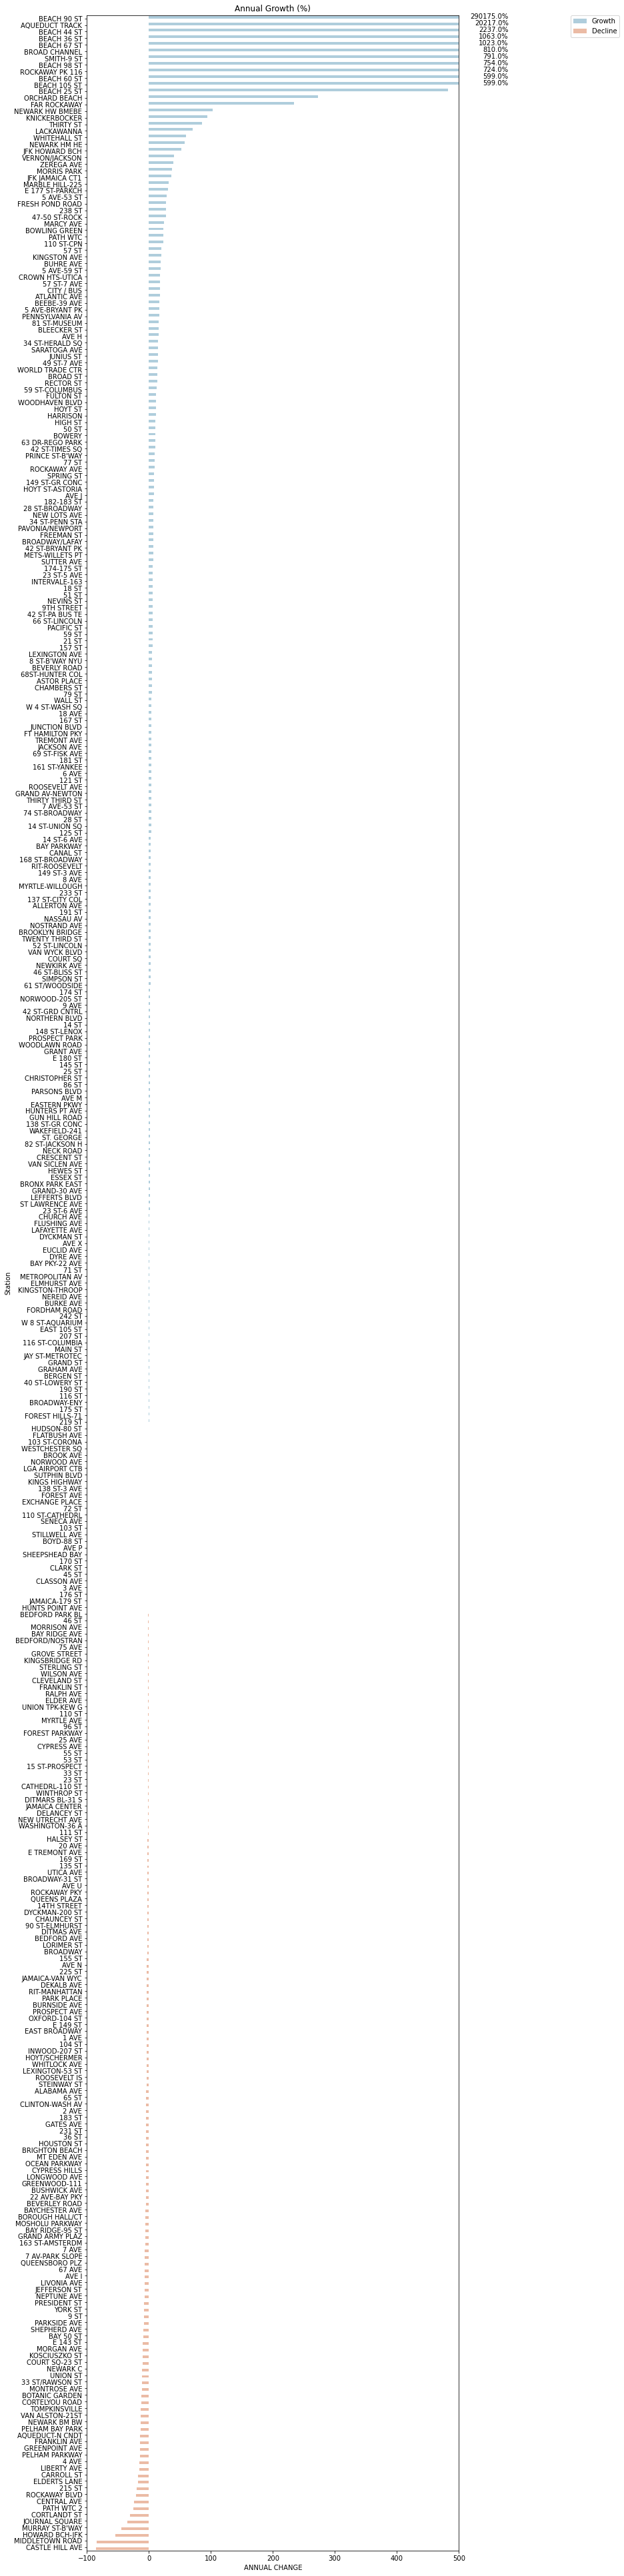

In [58]:
fig, ax = plt.subplots(figsize=(10, 70))
sns.barplot(data=temp2,
            x="ANNUAL CHANGE",
            y="Station",
           orient="h",
           hue="DESC",
           palette="RdBu_r")
ax.set_title("Annual Growth (December Throughput as % of January)");
ax.set_title("Annual Growth (%)");

for i in range(11):
    ax.annotate(f'{round(temp2.iloc[i]["ANNUAL CHANGE"],0)}%', xy=(580, i), annotation_clip=False, ha="right")

plt.xlim([-100, 500])
ax.legend(bbox_to_anchor=(1.3, 1), loc=2, borderaxespad=0.);

In [59]:
temp = temp.sort_values(by="ANNUAL CHANGE", ascending=True)
display(temp.tail(5))
print(f"The station with the highest usage growth in 2013 is station {temp.index[-1]}, with {round(temp['ANNUAL CHANGE'][-1], 2)}% annual growth")
display(temp.head(5))
print(f"The station with the highest usage decline in 2013 is station {temp.index[0]}, with {round(temp['ANNUAL CHANGE'][0], 2)}% annual growth")

,first,last,ANNUAL CHANGE,DESC
Station,,,,
BEACH 67 ST,8110.0,91093.0,1023.218249,Growth
BEACH 36 ST,3232.0,37599.0,1063.335396,Growth
BEACH 44 ST,1100.0,25706.0,2236.909091,Growth
AQUEDUCT TRACK,261.0,53027.0,20216.858238,Growth
BEACH 90 ST,28.0,81277.0,290175.000000,Growth


The station with the highest usage growth in 2013 is station BEACH 90 ST, with 290175.0% annual growth


,first,last,ANNUAL CHANGE,DESC
Station,,,,
CASTLE HILL AVE,323761.0,46871.0,-85.522963,Decline
MIDDLETOWN ROAD,67779.0,10806.0,-84.057009,Decline
HOWARD BCH-JFK,164901.0,76339.0,-53.706163,Decline
MURRAY ST-B'WAY,228579.0,126778.0,-44.536462,Decline
JOURNAL SQUARE,1223208.0,800613.0,-34.548090,Decline


The station with the highest usage decline in 2013 is station CASTLE HILL AVE, with -85.52% annual growth


That growth at BEACH 90 ST looks...other worldy. Let's take a closer look at that. 

In [60]:
temp[temp.index == "BEACH 90 ST"]

,first,last,ANNUAL CHANGE,DESC
Station,,,,
BEACH 90 ST,28.0,81277.0,290175.0,Growth


Evidently, BEACH 90 ST's first month recorded only 28 total passengers. Could this be true? 

In [61]:
master[master["Station"] == "BEACH 90 ST"].groupby(master.DATETIME.dt.month)[["PERIOD ENTRIES", "PERIOD EXITS", "THROUGHPUT"]].sum().rename_axis(index="Month")

,PERIOD ENTRIES,PERIOD EXITS,THROUGHPUT
Month,,,
1,19.0,9.0,28.0
2,0.0,14.0,14.0
3,20.0,34.0,54.0
4,3.0,14.0,17.0
5,2138.0,1941.0,4079.0
6,28754.0,26046.0,54800.0
7,39189.0,34057.0,73246.0
8,30518.0,29207.0,59725.0
9,21176.0,19889.0,41065.0


In [62]:
del(temp)

It sure does look true, and a [quick Google search explains why](https://en.wikipedia.org/wiki/Beach_90th_Street_station): Hurricane Sandy destroyed a significant portion of the track, and repairs were not completed until spring of 2013. This also explains why 4 of the top 5 growing stations were all on the BEACH ST route. 

This leads to the question of how the stations received any passengers at all, but information indicates there were shuttles through this station as well - perhaps those busses utilized optional turnstiles? The data checks out, but this is certainly an area for further exploration

### 5. What dates are the least busy? 
Can we identify days on which stations were not operating at full capacity or closed entirely?

Now, the second component of this is particularly interesting - are we looking at days where stations in aggregate are running low, or do we also need to run this analysis for each of our 380 stations and check them individually? Given the scope of the project at hand, I assume the former, though we already know some extraneous factors (e.g. Hurricane Sandy) will cause some of the stations to be running low on capacity for the early phases of the year

One metric we can use to support this analysis is the concept of the percentile; how many values fall below a certain value? Pandas automatically calculates the traditional percentiles of 25, 50, and 75, as well as the mean (average) for each column. Calculating these for THROUGHPUT should be more than sufficient to find days that are operating at low capacity; days below the 25th percentile are obvious answers to this question.

#### Part 1: Calendar Year Q1 (As directed)
Using data only from January-March

In [63]:
temp = master[master.DATETIME < "2013-04-01"].set_index("DATETIME").resample("D").THROUGHPUT.sum()
through_50 = temp.describe()["50%"]
through_25 = temp.describe()["25%"]
through_mean = temp.describe()["mean"]

Let's first take a look at an old trusty line graph and see if there's any seasonality represented in throughput

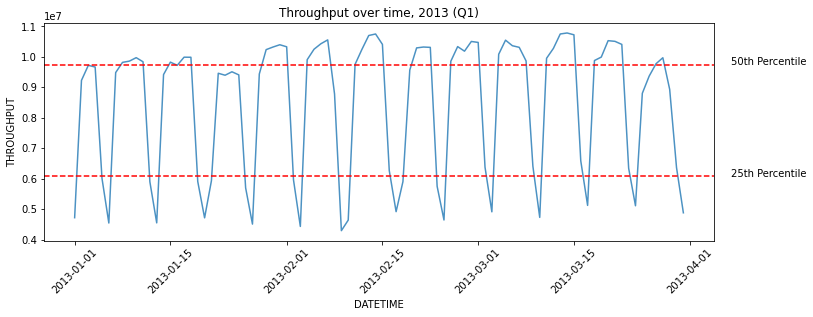

In [64]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.lineplot(data = master[master.DATETIME < "2013-04-01"].set_index("DATETIME").resample("D").THROUGHPUT.sum().reset_index(),
            x = "DATETIME",
            y = "THROUGHPUT",
            alpha = .8)

plt.axhline(y=through_50, color='r', linestyle='--');
plt.axhline(y=through_25, color='r', linestyle='--');
ax.annotate("50th Percentile", xy=(734965, through_50), annotation_clip=False);
ax.annotate("25th Percentile", xy=(734965, through_25), annotation_clip=False);

plt.xticks(rotation=45)
plt.title("Throughput over time, 2013 (Q1)");

This data from Q1 suggests a regular rise and fall of traffic - perhaps on a weekly basis? Let's see if we can find any details digging into trends based on day of week. 

In [65]:
temp = temp.reset_index().sort_values(by="THROUGHPUT", ascending=False).reset_index(drop=True).reset_index()

### ANSWER

LEAST BUSY DAY: February 09


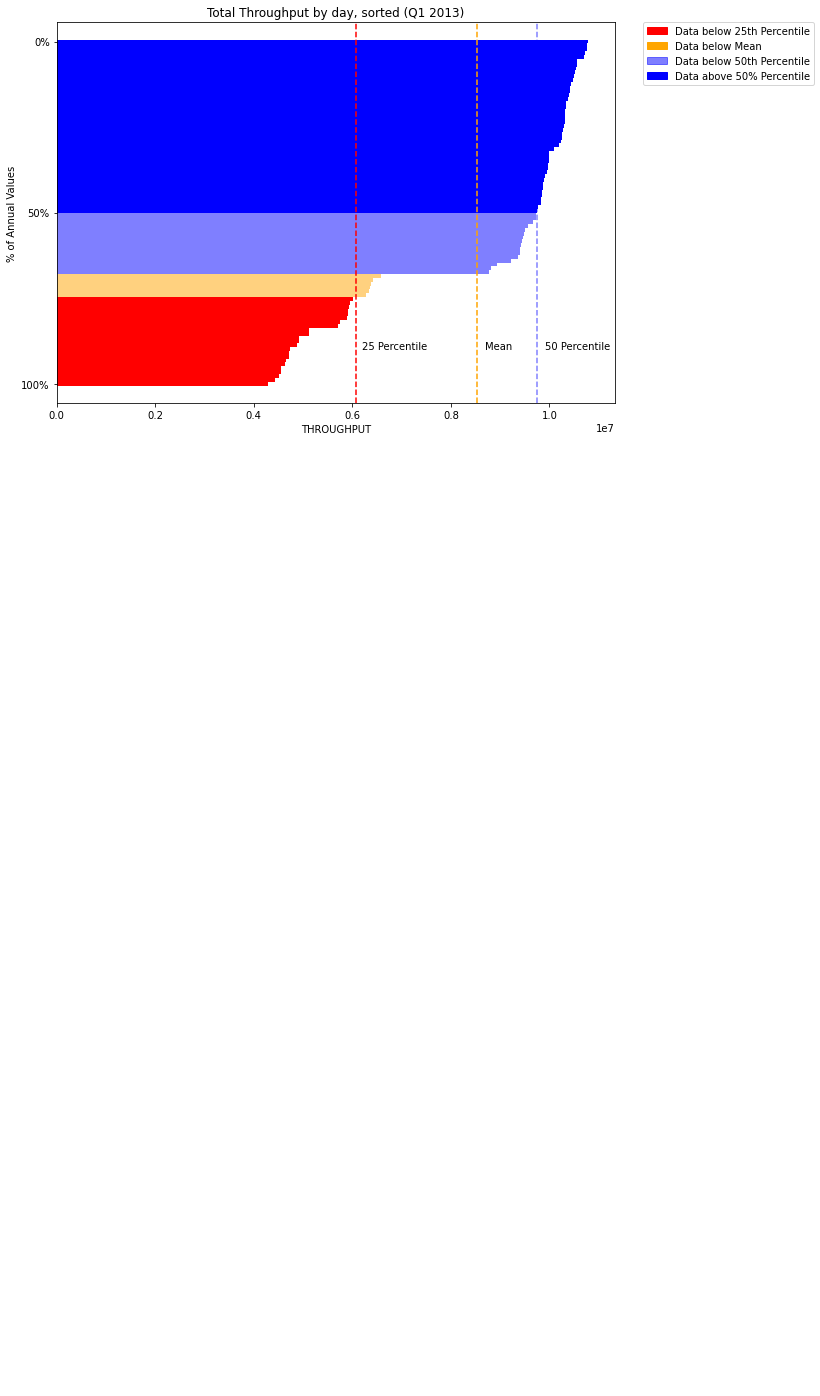

In [66]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(data=temp[temp.THROUGHPUT <= through_25], y="index", width="THROUGHPUT", height=1, color="r")
ax.barh(data=temp[(temp.THROUGHPUT > through_25)&(temp.THROUGHPUT <= through_mean)], y="index", width="THROUGHPUT", height=1, color="orange", alpha=.5)
ax.barh(data=temp[(temp.THROUGHPUT > through_mean)&(temp.THROUGHPUT<=through_50)], y="index", width="THROUGHPUT", height=1, color="blue", alpha=.5)
ax.barh(data=temp[temp.THROUGHPUT>through_50], y="index", width="THROUGHPUT", height=1, color="blue")
ax.set_xlabel("THROUGHPUT")
plt.gca().invert_yaxis()
plt.ylabel("% of Annual Values")
plt.yticks(np.linspace(0, max(temp.reset_index().index),3), ["0%", "50%", "100%"])

ax.axvline(x=through_mean, color='orange', linestyle='--');
ax.axvline(x=through_25, color='r', linestyle='--');
ax.axvline(x=through_50, color='blue', linestyle='--', alpha=.5);
ax.annotate("25 Percentile", (6200000,80), color="black")
ax.annotate("Mean", (8700000,80), color="black")
ax.annotate("50 Percentile", (9900000,80), color="black")
ax.set_title("Total Throughput by day, sorted (Q1 2013)");
ax.annotate(f"LEAST BUSY DAY: {temp.iloc[-1]['DATETIME'].strftime('%B %d')}", (1000000,350), color='black');
print(f"LEAST BUSY DAY: {temp.iloc[-1]['DATETIME'].strftime('%B %d')}");
      
red = mpatches.Patch(color='red', label='Data below 25th Percentile')
orange = mpatches.Patch(color='orange', label='Data below Mean')
blue = mpatches.Patch(color='blue', alpha=.5, label='Data below 50th Percentile')
blue_full = mpatches.Patch(color='blue', label='Data above 50% Percentile')
plt.legend(handles=[red, orange, blue, blue_full], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [67]:
over_25 = temp[temp["THROUGHPUT"] > through_25].groupby(temp["DATETIME"].dt.weekday).count()["THROUGHPUT"]
under_25 = temp[temp["THROUGHPUT"] <= through_25].groupby(temp["DATETIME"].dt.weekday).count()["THROUGHPUT"]
temp["PERCENTILE"] = np.nan
temp.loc[temp["THROUGHPUT"] <= through_25, "PERCENTILE"] = "25 or Below"
temp.loc[temp["THROUGHPUT"] > through_25, "PERCENTILE"] = "26 or Above"

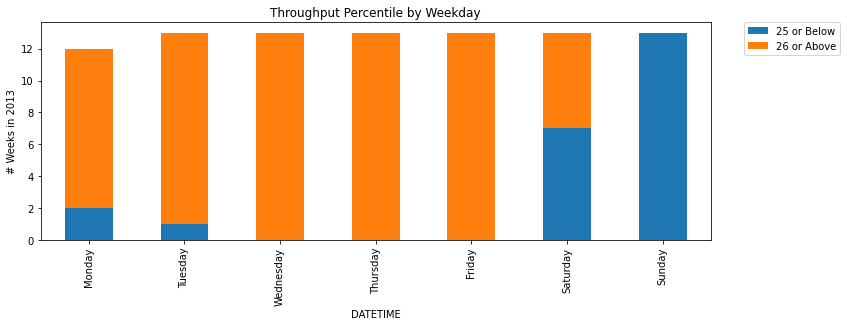

In [68]:
ax = temp.groupby([temp["DATETIME"].dt.weekday, "PERCENTILE"]).count().THROUGHPUT.unstack().plot.bar(stacked=True, figsize=(12,4))
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
#ax.legend(loc="upper left");
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ax.set_ylabel("# Weeks in 2013");
ax.set_title("Throughput Percentile by Weekday");

Wow - not a single Sunday in Q1 has a throughput that breaks the 25 percentile

It is clear that weekends are by far the least busy for the MTA system as a whole, with Sundays seeing the most significant falloff. 

The MTA could interpret this trend in one of two ways 

1 - With reduced traffic comes reduced need for administrative oversight. They could reduce employee hours on the weekends.
2 - If Weekends continuously have less traffic than the weekdays, this presents an opportunity to improve weekend throughput. The MTA could look into reduced weekend fare or special offers to get more people riding the subway on the weekends. 

Of the two, I think interpretation 1 holds more weight; odds are high that most of the subway traffic is from business commuters, and experience informs me that it is almost impossible to incentivize leisure travel to reach the same level as mandated travel.

Interpretation 1 also suggests that maintanence, if and when it is required, will be least disruptive to passengers if conducted on Sundays

### PERSONAL INVESTIGATION Q5 Part 2, Annual trends
I'm curious if the trends above hold for the whole year, so I quickly modeled it out. It's the same process, just without the filter for Q1 dates.

In [69]:
temp = master.set_index("DATETIME").resample("D").THROUGHPUT.sum()
through_50 = temp.describe()["50%"]
through_25 = temp.describe()["25%"]
through_mean = temp.describe()["mean"]

Line graph:

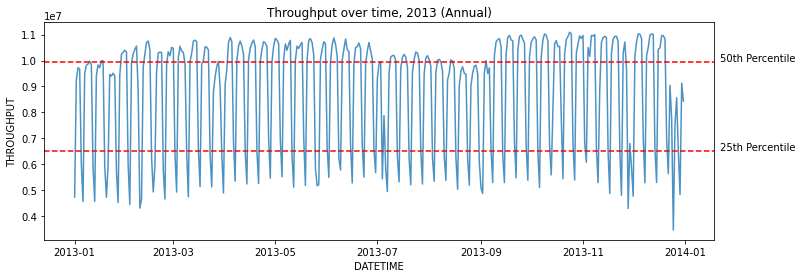

In [70]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.lineplot(data = master.set_index("DATETIME").resample("D").THROUGHPUT.sum().reset_index(),
            x = "DATETIME",
            y = "THROUGHPUT",
            alpha = .8)

plt.axhline(y=through_50, color='r', linestyle='--');
plt.axhline(y=through_25, color='r', linestyle='--');
plt.title("Throughput over time, 2013 (Annual)");
ax.annotate("50th Percentile", xy=(735255, through_50), annotation_clip=False);
ax.annotate("25th Percentile", xy=(735255, through_25), annotation_clip=False);

This graph suggests similar trends to the Q1 graph, in that it shows a cyclical rise and fall of ridership throughout the course of the 7-day week, but with the additional data, indicates there might be a dip in the holiday season. Let's see if there are any changes in day-of-week trends with the expanded time horizon

In [71]:
temp = temp.reset_index().sort_values(by="THROUGHPUT", ascending=False).reset_index(drop=True).reset_index()

LEAST BUSY DAY: December 25


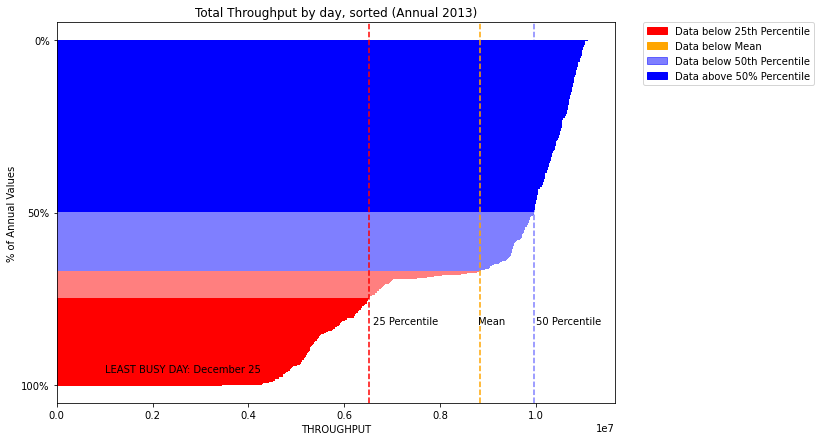

In [72]:
fig, ax = plt.subplots(figsize=(10, 7))
#sns.barplot(data=temp[temp["THROUGHPUT"] > through_25], y="index", x="THROUGHPUT", orient="h", color="b")
#sns.barplot(data=temp[temp["THROUGHPUT"] < through_25], y="index", x="THROUGHPUT", orient="h", color="r")
ax.barh(data=temp[temp.THROUGHPUT <= through_25], y="index", width="THROUGHPUT", height=1, color="r")
ax.barh(data=temp[(temp.THROUGHPUT > through_25)&(temp.THROUGHPUT <= through_mean)], y="index", width="THROUGHPUT", height=1, color="r", alpha=.5)
ax.barh(data=temp[(temp.THROUGHPUT > through_mean)&(temp.THROUGHPUT<=through_50)], y="index", width="THROUGHPUT", height=1, color="b", alpha=.5)
ax.barh(data=temp[temp.THROUGHPUT>through_50], y="index", width="THROUGHPUT", height=1, color="b")
ax.set_xlabel("THROUGHPUT")
plt.gca().invert_yaxis()
plt.ylabel("% of Annual Values")
plt.yticks(np.linspace(0, max(temp.reset_index().index),3), ["0%", "50%", "100%"])

ax.axvline(x=through_mean, color='orange', linestyle='--');
ax.axvline(x=through_25, color='r', linestyle='--');
ax.axvline(x=through_50, color='b', alpha=.5, linestyle='--');
ax.annotate("25 Percentile", (6600000,300), color="black")
ax.annotate("Mean", (8800000,300), color="black")
ax.annotate("50 Percentile", (10000000,300), color="black")
ax.set_title("Total Throughput by day, sorted (Annual 2013)");
ax.annotate(f"LEAST BUSY DAY: {temp.iloc[-1]['DATETIME'].strftime('%B %d')}", (1000000,350), color='black');
print(f"LEAST BUSY DAY: {temp.iloc[-1]['DATETIME'].strftime('%B %d')}");
      
red = mpatches.Patch(color='red', label='Data below 25th Percentile')
orange = mpatches.Patch(color='orange', label='Data below Mean')
blue = mpatches.Patch(color='blue', alpha=.5, label='Data below 50th Percentile')
blue_full = mpatches.Patch(color='blue', label='Data above 50% Percentile')
plt.legend(handles=[red, orange, blue, blue_full], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [73]:
temp = temp.drop(columns="index")

This comes as no surprise, but the least busy day of the entire year is Christmas day - a federal holiday that is recognized across all industries, countries, and even celebrtated (in different ways) by people of different faiths. This also aligns with what we observed in the linechart earlier.

Holidays not withstanding, can we generalize anything further about these days where stations are operating at low capacity? Maybe whether there's some trend based on day of the week? Let's take a look

In [74]:
over_25 = temp[temp["THROUGHPUT"] > through_25].groupby(temp["DATETIME"].dt.weekday).count()["THROUGHPUT"]
under_25 = temp[temp["THROUGHPUT"] <= through_25].groupby(temp["DATETIME"].dt.weekday).count()["THROUGHPUT"]
temp["PERCENTILE"] = np.nan
temp.loc[temp["THROUGHPUT"] <= through_25, "PERCENTILE"] = "25 or Below"
temp.loc[temp["THROUGHPUT"] > through_25, "PERCENTILE"] = "26 or Above"

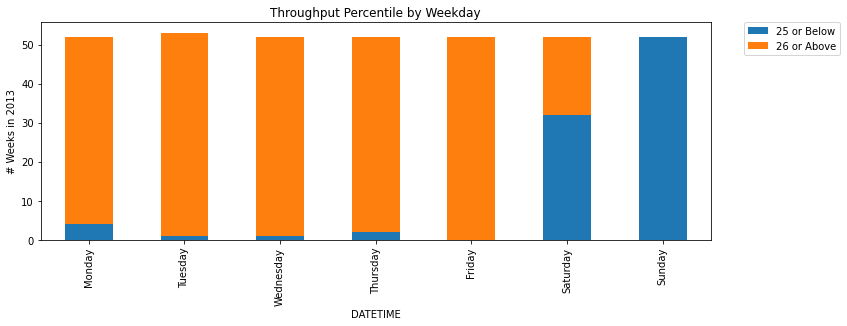

In [75]:
ax = temp.groupby([temp["DATETIME"].dt.weekday, "PERCENTILE"]).count().THROUGHPUT.unstack().plot.bar(stacked=True, figsize=(12,4))
ax.set_xticklabels(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
#ax.legend(loc="upper left");
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ax.set_ylabel("# Weeks in 2013");
ax.set_title("Throughput Percentile by Weekday");

Wow - in all 52 weeks of the year, every Sunday's total throughput fell somewhere below the 25th percentile. A similar trend holds true for Saturday, but less pronounced - only ~30 Saturdays fell below the 25th percentile in 2013. 

The trends and interepretations are the same as those found from Q1, but as there is now more data to support these trends, the conclusions and actions items can be trusted more strongly.

### Bonus:  What hour is the busiest for station CANAL ST in Q1 2013?

NOTE: Because the MTA reports turnstile data on a 4-hour interval, it is not possible to determine the businest hour, per se. We <b> can </b>, however, determine the busiest 4 hour block. 

In [76]:
temp = master[(master.DATETIME < "04-01-2013") & (master.Station == "CANAL ST")]

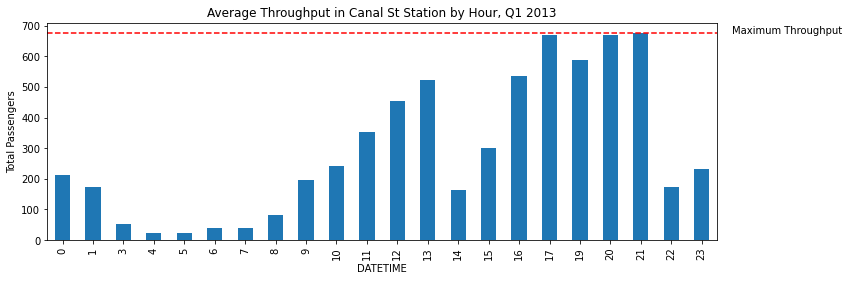

In [77]:
fig, ax = plt.subplots(figsize=(12, 4))
temp.groupby(temp["DATETIME"].dt.hour).mean()["THROUGHPUT"].plot.bar()
plt.axhline(y=temp.groupby(temp["DATETIME"].dt.hour).mean()["THROUGHPUT"].max(), color='r', linestyle='--');
plt.annotate("Maximum Throughput", (22, temp.groupby(temp["DATETIME"].dt.hour).mean()["THROUGHPUT"].max()), annotation_clip=False)
plt.title("Average Throughput in Canal St Station by Hour, Q1 2013");
plt.ylabel("Total Passengers");

In [78]:
temp = temp.groupby(temp.DATETIME.dt.hour).mean()
temp_max = temp['THROUGHPUT'].max()

In [79]:
print(f"The busiest 4-hour interval in Canal St Station during Q1 2013 was {temp.loc[temp.THROUGHPUT == temp_max].index[0]-4}:00 - {temp.loc[temp.THROUGHPUT == temp_max].index[0]}:00, calculated using reports collected at {temp.loc[temp.THROUGHPUT == temp_max].index[0]}:00")

The busiest 4-hour interval in Canal St Station during Q1 2013 was 17:00 - 21:00, calculated using reports collected at 21:00


In [80]:
#del(lim,field_list,over_25,under_25,station_list, temp, temp_max, through_25, through_50, through_mean, url)

## Data Visualization
All the exercises here will be visualized using Q1 data, so I might as well make that dataframe

In [81]:
q1 = master[(master.DATETIME < "04-01-2013")]

### DV 1: Plot the daily row counts for data files in Q1 2013.

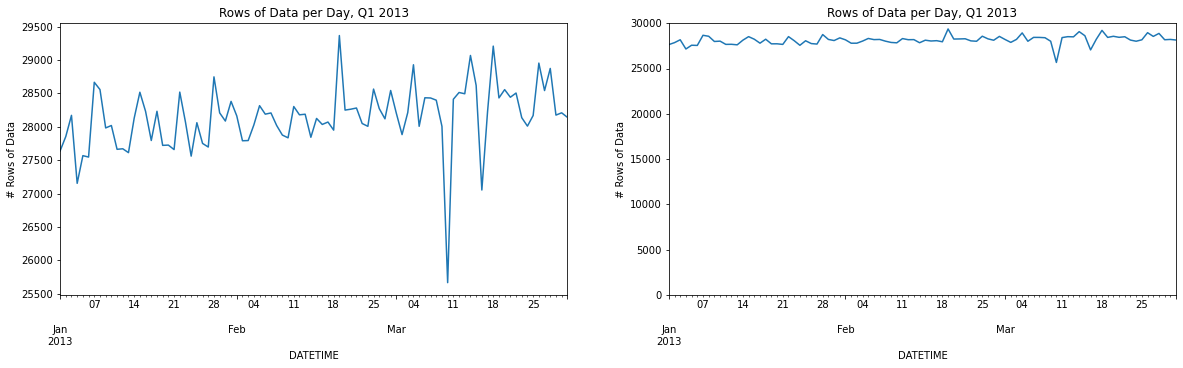

In [82]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5));
for ax in [ax1, ax2]:
    q1.set_index("DATETIME").resample("D").count()["THROUGHPUT"].plot(ax=ax)
    ax.set_title("Rows of Data per Day, Q1 2013");
    ax.set_ylabel("# Rows of Data")
ax2.set_ylim([0,30000]);

There is a dip around March 10-11, but the MTA still collects 25,000+ rows of data every day

### DV 2: Plot the daily total number of entries & exits across the system for Q1 2013.

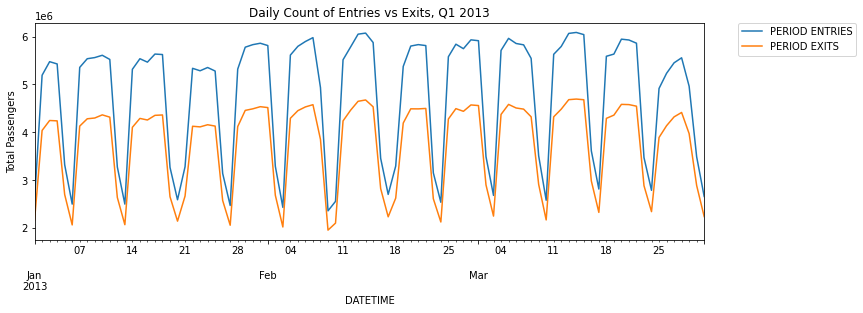

In [83]:
q1.set_index("DATETIME").resample("D").sum()[["PERIOD ENTRIES", "PERIOD EXITS"]].plot(figsize=(12,4));
plt.title("Daily Count of Entries vs Exits, Q1 2013")
plt.ylabel("Total Passengers")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

This looks in line with what we discovered in data analysis Q2 - either the MTA has serious issues collecting exit data, or it's mislabeling some exits as entries. 

### DV 3: Plot the mean and standard deviation of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

In [84]:
q1[q1.Station == "34 ST-PENN STA"].set_index("DATETIME").resample("D").sum()\
                                                    .resample("M")[["PERIOD ENTRIES","PERIOD EXITS"]].agg(["mean", "std"])

PERIOD ENTRIES                 PERIOD EXITS              
                     mean           std           mean           std
DATETIME                                                            
2013-01-31  142353.483871  45087.437378  124703.709677  36993.249980
2013-02-28  144728.142857  48553.235268  125960.714286  40504.421790
2013-03-31  147568.838710  43581.892120  130818.741935  35230.755052

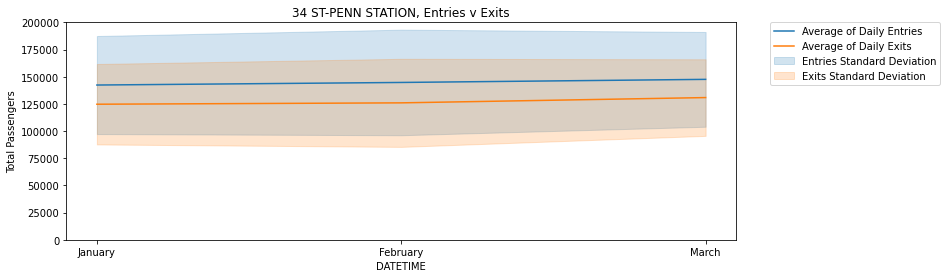

In [85]:
fig, ax = plt.subplots(figsize=(12, 4))
temp = q1[q1.Station == "34 ST-PENN STA"].set_index("DATETIME").resample("D").sum().reset_index()
sns.lineplot(data = temp, x=temp.DATETIME.dt.month, y="PERIOD ENTRIES", ci="sd")
sns.lineplot(data = temp, x=temp.DATETIME.dt.month, y="PERIOD EXITS", ci="sd")
ax.set_ylim([0,200000]);
plt.xticks(np.linspace(1,3,3), ["January", "February", "March"]);
ax.set_title("34 ST-PENN STATION, Entries v Exits");
ax.set_ylabel("Total Passengers");
ax.get_lines()[0].set_label("Average of Daily Entries")
ax.collections[0].set_label('Entries Standard Deviation')
ax.get_lines()[1].set_label("Average of Daily Exits")
ax.collections[1].set_label('Exits Standard Deviation')

#ax.legend(labels=['PERIOD ENTRIES', 'PERIOD EXITS']);
#ax.legend([ax.collections[1]], ['Stuff'])
#ax.legend(self.labels,colorList[:len(self.labels)])

#ax.legend(loc="lower right");
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### DV 4: Plot 25/50/75 percentile of the daily total number of entries & exits for each month in Q1 2013 for station 34 ST-PENN STA.

In [86]:
q1[q1.Station == "34 ST-PENN STA"].set_index("DATETIME").resample("D").sum()\
                                                    .resample("M")[["PERIOD ENTRIES","PERIOD EXITS"]].describe()

PERIOD ENTRIES                                                 \
                    count           mean           std      min      25%   
DATETIME                                                                   
2013-01-31           31.0  142353.483871  45087.437378  65882.0  86212.5   
2013-02-28           28.0  144728.142857  48553.235268  53684.0  91983.0   
2013-03-31           31.0  147568.838710  43581.892120  66316.0  96723.5   

                                         PERIOD EXITS                 \
                 50%       75%       max        count           mean   
DATETIME                                                               
2013-01-31  170646.0  173188.0  179904.0         31.0  124703.709677   
2013-02-28  176110.0  178376.5  185033.0         28.0  125960.714286   
2013-03-31  173828.0  177712.5  191379.0         31.0  130818.741935   

                                                                           
                     std      min      25%       50%        75%       max  
DATETIME                                                                   
2013-01-31  36993.249980  59263.0  81194.5  145841.0  151530.00  157787.0  
2013-02-28  40504.421790  50916.0  84468.0  149998.0  154088.25  165639.0  
2013-03-31  35230.755052  60973.0  94321.0  148672.0  155684.50  167867.0

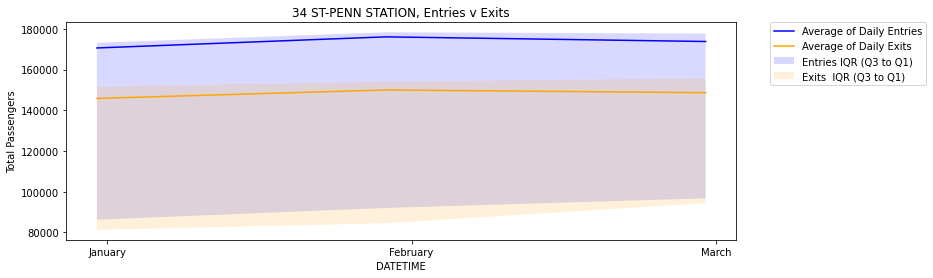

In [87]:
fig, ax = plt.subplots(figsize=(12, 4))
temp = q1[q1.Station == "34 ST-PENN STA"].set_index("DATETIME").resample("D").sum()\
                                                    .resample("M")[["PERIOD ENTRIES","PERIOD EXITS"]].describe().reset_index()
sns.lineplot(data = temp, x="DATETIME", y=temp.loc[:, "PERIOD ENTRIES"]["50%"], ci=None, color="blue")
sns.lineplot(data = temp, x="DATETIME", y=temp.loc[:, "PERIOD EXITS"]["50%"], ci=None, color="orange")

ax.fill_between(temp.DATETIME, temp.loc[:, "PERIOD ENTRIES"]["25%"], temp.loc[:, "PERIOD ENTRIES"]["75%"],
                facecolor="blue", alpha=.15)

ax.fill_between(temp.DATETIME, temp.loc[:, "PERIOD EXITS"]["25%"], temp.loc[:, "PERIOD EXITS"]["75%"],
                facecolor="orange", alpha=.15)


#ax.set_ylim([0,200000]);
ax.set_title("34 ST-PENN STATION, Entries v Exits");
#ax.set_ylabel("Total Passengers");
ax.get_lines()[0].set_label("Average of Daily Entries")
ax.collections[0].set_label('Entries IQR (Q3 to Q1)')
ax.get_lines()[1].set_label("Average of Daily Exits")
ax.collections[1].set_label('Exits  IQR (Q3 to Q1)')
plt.xticks(np.linspace(min(ax.get_xticks()),max(ax.get_xticks()),3), ["January", "February", "March"]);
ax.set_ylabel("Total Passengers")

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);



Looking at the table and graph above, it is clear that the 75th percentile is much closer in value to the 50th than the 50th is from the 25th. But what does this mean? 

It means that average throughput in 34 ST Penn Station is stable at around ~14500 entries and ~12500 exits for most of the day, but falls and fluctuates <i> drastically </i> in off-peak hours. 

Station managers can take advantage of this fact by scheduling maintanence and repairs around throughput to minimize inconvenience to riders

### DV 5: Plot the daily number of closed stations and number of stations that were not operating at full capacity in Q1 2013.

For the sake of this question, we'll define closed stations and stations not operating at full capacity as those operating below their station's specific 25th percentile.

We'll define stations with 0 daily throughput (0 entries and 0 exits) as closed.

In [88]:
temp = q1.groupby(["Station"]).resample("D", on="DATETIME").sum().reset_index()
temp_desc = temp.groupby("Station").describe()["THROUGHPUT"]
temp["CAPACITY"] = np.nan

for station in set(q1.Station.unique()):
    temp.loc[(temp['Station'] == station) & (temp["THROUGHPUT"] == 0), ["CAPACITY"]] = "CLOSED"
    temp.loc[(temp['Station'] == station) & (temp["THROUGHPUT"] < temp_desc.loc[station, "25%"]) & (temp["THROUGHPUT"] > 0), ["CAPACITY"]] = "BELOW CAPACITY"
    temp.loc[(temp['Station'] == station) & (temp["THROUGHPUT"] >= temp_desc.loc[station, "25%"]), ["CAPACITY"]] = "ACCEPTABLE CAPACITY"

In [89]:
temp = temp.groupby(["CAPACITY"]).resample("D", on="DATETIME").count()["Station"].reset_index()

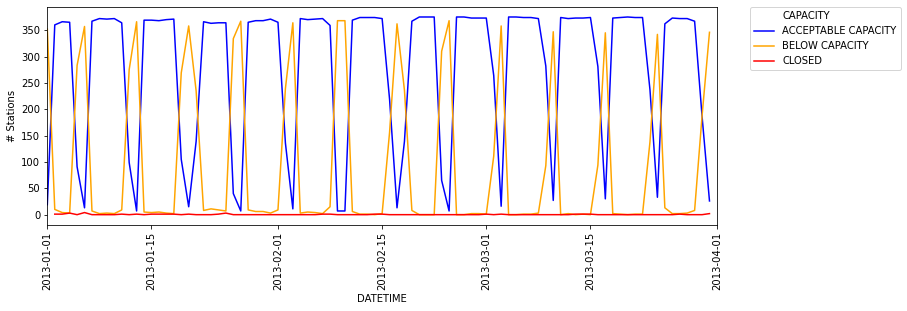

In [90]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.lineplot(data= temp, x="DATETIME", y="Station", hue="CAPACITY", palette=["blue","orange","red"])
plt.xlim(["2013-01-01", "2013-04-01"])
plt.xticks(rotation=90);
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
ax.set_ylabel("# Stations");

This cyclical graph looks in line with what we observed earlier; looking at the MTA's aggregate activity revealed ridership falls drastically on weekends and particularly hard on Sundays, only be resume again during the work week